In [279]:
import os
import sys
import json
import urllib.request
import pandas as pd

from bs4 import BeautifulSoup
from urllib.request import urlopen

# API 호출에 필요한 데이터 추출 코드
url = "https://search.shopping.naver.com/search/category?catId=50001801&frm=NVSHCAT&origQuery&pagingIndex=1&pagingSize=40&productSet=total&query&sort=rel&timestamp=&viewType=list"
a = url.split('/')
number = a[4].split('=')[1]

if len(number) != 8:
    number = number.split('&')[0]
html = urlopen(url)

soup = BeautifulSoup(html.read(), "html.parser")
result = soup.find("div", {"class": "filter_finder_row__1rXWv"})
result2 = soup.find("span", {"class": "filter_num__1SlWk"})
a_result = result.find("a")
a_result = result.find_all("span")

index = 0

for i in range(0, len(a_result)):
    a_text = a_result[i].text
    if a_text == result2.text:
        index = i - 1
        break
        
name = a_result[index].text
# print(name.text)

name = str(name)
number = str(number)

print(number, name)




# API 호출 코드
date_arr = ['2018-01-01', '2018-12-11', '2019-01-01', '2019-12-11', '2020-01-01', '2020-12-11']

client_id = "my_api_id"
client_secret = "my_api_key"
url = "https://openapi.naver.com/v1/datalab/shopping/categories";
body = "{\"startDate\":\"2018-01-01\",\"endDate\":\"2020-12-11\",\"timeUnit\":\"date\",\"category\":[{\"name\":\"" + name + "\",\"param\":[\"" + number + "\"]}]}";

print(body)
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()

if(rescode==200):
    response_body = response.read()
    js = json.loads(response_body)
else:
    print("Error Code:" + rescode)

    
    
    

# csv 파일 변환 코드 
title = js["results"][0]["title"]
category = js["results"][0]["category"]
category = str(category[0])

for ch in title:
    if ch == '/':
        title = title.replace('/', '_')
        break
        
date = []
ratio = []

for data in js["results"][0]["data"]:
    date.append(data["period"])
    ratio.append(data["ratio"])

start_date = date[0][0:4]
end_date = date[len(date)-1]

data = pd.Series(ratio, index=date)
data.index.name = "Date"

shopping_df = pd.DataFrame(data)
shopping_df.columns = ['Ratio']
shopping_df

file_name = title + '_' + category  + '.csv'
print(file_name)

start_date = date[0]
print(start_date)

shopping_df.to_csv(file_name, encoding='utf-8-sig')

50001801 화분
{"startDate":"2018-01-01","endDate":"2020-12-11","timeUnit":"date","category":[{"name":"화분","param":["50001801"]}]}
화분_50001801.csv
2018-01-01


In [9]:
shopping_df.to_csv(file_name, encoding='utf-8-sig')

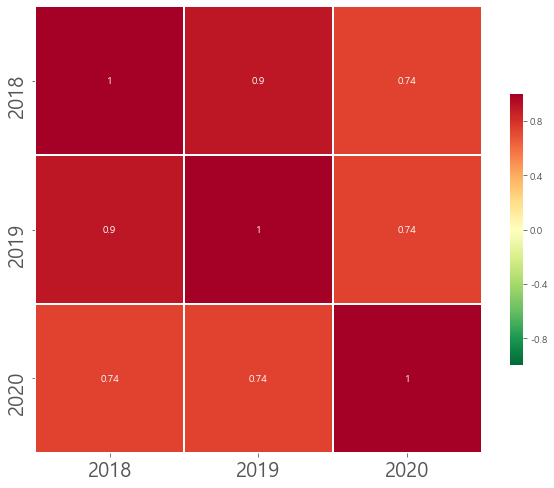

              2018       2019       2020
2018      1.000000   0.903551   0.736848
2019      0.903551   1.000000   0.735653
2020      0.736848   0.735653   1.000000
Average  21.494157  28.038015  49.674463


In [280]:
# 각 년도 별로 pearson correlation 분석.
# pearson correlation 값을 heat map으로 나타내보기.

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv(file_name)
data = data['Ratio']

data1 = data.loc[31:344]
data_2018 = []
sum_2018 = 0

for ratio in data1:
    data_2018.append(ratio)
    sum_2018 += ratio

data2 = data.loc[396:709]
data_2019 = []
sum_2019 = 0

for ratio in data2:
    data_2019.append(ratio)
    sum_2019 += ratio
    
    
data3 = data.loc[761:]
data_2020 = []
sum_2020 = 0

for ratio in data3:
    data_2020.append(ratio)
    sum_2020 += ratio
    
all_data = []
all_data.append(data_2018)
all_data.append(data_2019)
all_data.append(data_2020)

df = pd.DataFrame(all_data).T
df.columns = ['2018', '2019', '2020']

skp = [(sum_2018 / len(data_2018), sum_2019 / len(data_2019), sum_2020 / len(data_2020))]
avg_data = pd.DataFrame(skp, columns=df.columns, index=['Average'])

corr = df.corr(method='pearson')
plt.figure(figsize=(10,10))
ax = sns.heatmap(corr, annot=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1,
            square=True, cmap='RdYlGn_r')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.show()

corr = corr.append(avg_data)

corr_file_name = title + '_' + category  + '_corr.csv'
corr.to_csv(corr_file_name, encoding='utf-8-sig')

print(corr)

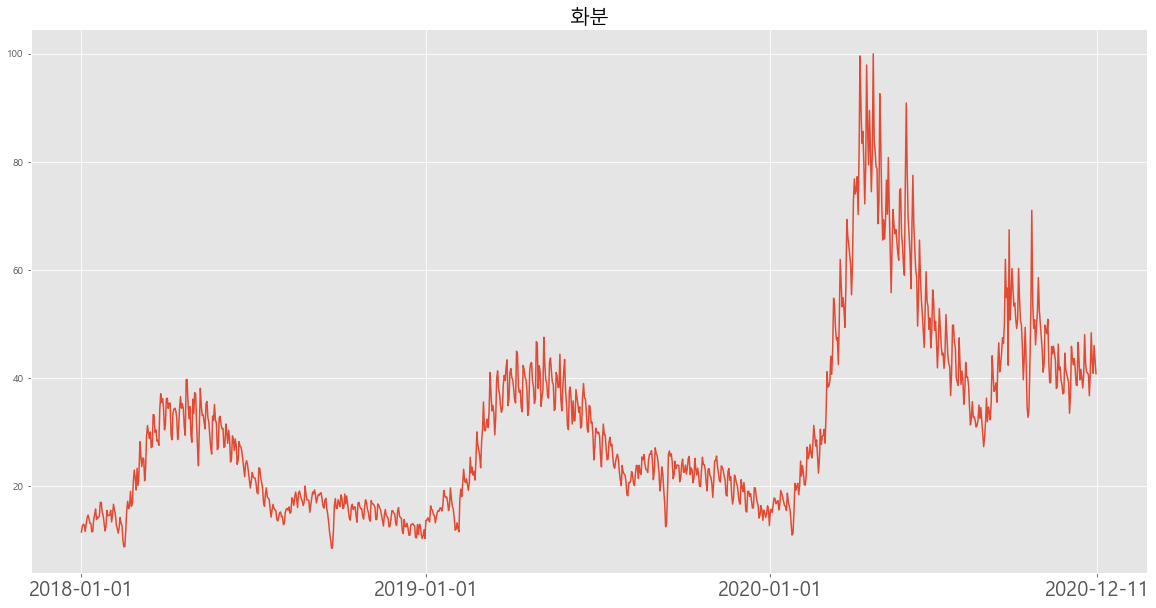

In [281]:
# 3년 동안의 클릭량을 matplotlib 이용해 그래프로 visualization.

a = np.arange(0, 2, 0.2)

plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

plt.figure(figsize=(20,10))
plt.plot(shopping_df)
plt.title(name, fontsize=20)
plt.xticks([0, 365, 730, len(shopping_df)], labels=['2018-01-01', '2019-01-01', '2020-01-01', '2020-12-11'], fontsize=20)

fig = plt.gcf()
graph_file_name = title + '_' + category  + '_graph.png'
fig.savefig(graph_file_name, dpi=fig.dpi)

In [282]:
# 일별 확진자 데이터와 20년도 클릭량 간의 pearson correlation 분석.

c_data = pd.read_csv('corona_date.csv')
c_data = c_data['확진자']
c_data = c_data.loc[:298]

corona_data = []

for count in c_data:
    corona_data.append(count)

r_data = pd.read_csv(file_name)
r_data = r_data['Ratio']

r_data = r_data.loc[777:]

ratio_data = []

for ratio in r_data:
    ratio_data.append(ratio)

all_data = []
all_data.append(corona_data)
all_data.append(ratio_data)

print(corona_data[20])
print(ratio_data[20])

df = pd.DataFrame(all_data).T
df.columns = ['일별 확진자', 'Ratio']

corr = df.corr(method='pearson')
corr_file_name = 'Pearson_' + title + '_' + category  + '_corr.csv'
corr.to_csv(corr_file_name, encoding='utf-8-sig')

corr

367.0
54.81482


,일별 확진자,Ratio
일별 확진자,1.000000,-0.384154
Ratio,-0.384154,1.000000


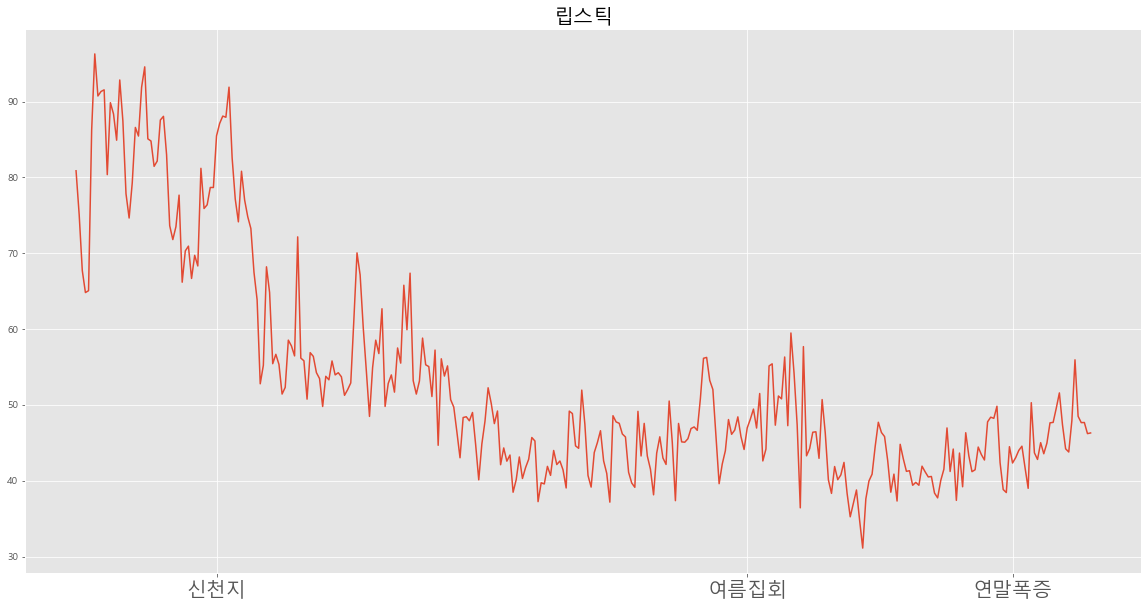

In [36]:
# 코로나 발생 이후 상품의 클릭량 그래프로 visualization.

df_2020 = shopping_df['Ratio'][750:]

plt.rc('font', family = 'Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

plt.figure(figsize=(20,10))
plt.plot(df_2020)
plt.title(name, fontsize=20)
plt.xticks([45, 215, 300], labels=['신천지', '여름집회', '연말폭증'], fontsize=20)

fig = plt.gcf()
graph_file_name = '2020_' + title + '_' + category  + '_graph.png'
fig.savefig(graph_file_name, dpi=fig.dpi)